# Histopathologic Cancer Detection

## **GitHub Repository URL:** https://github.com/Alisherg/kaggle/blob/main/cancer-detection/histopathologic-cancer-detection.ipynb

This competition is a binary image classification task. The goal is to develop a model that can identify the presence of metastatic cancer in small 96x96 pixel image patches taken from larger digital pathology scans of lymph node sections. Each patch is to be classified as either containing tumor tissue (label 1) or not (label 0). This is a supervised learning problem.

### Data Description
* **Data Type:** RGB color images.
* **Image Size:** Each image patch is 96x96 pixels.

* **Training set:** Approximately 220,025 labeled images.
* **Test set:** Approximately 57,458 unlabeled images (for prediction and submission).

* **Labels:** Provided in a CSV file (`train_labels.csv`) with `id` (image filename without extension) and `label` (0 or 1).
* `1`: The center 32x32px region of the 96x96px patch contains at least one pixel of tumor tissue.
* `0`: No tumor tissue in the center 32x32px region.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import zipfile
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

2025-05-24 05:40:37.576073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748065237.816504      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748065237.898963      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
TRAIN_IMAGE_DIR = '/kaggle/input/histopathologic-cancer-detection/train'
TEST_IMAGE_DIR = '/kaggle/input/histopathologic-cancer-detection/test'
TRAIN_LABELS_PATH = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

# Check if paths exist
print(f"Train image directory: {TRAIN_IMAGE_DIR}, Exists: {os.path.exists(TRAIN_IMAGE_DIR)}")
print(f"Test image directory: {TEST_IMAGE_DIR}, Exists: {os.path.exists(TEST_IMAGE_DIR)}")
print(f"Train labels CSV: {TRAIN_LABELS_PATH}, Exists: {os.path.exists(TRAIN_LABELS_PATH)}")

Train image directory: /kaggle/input/histopathologic-cancer-detection/train, Exists: True
Test image directory: /kaggle/input/histopathologic-cancer-detection/test, Exists: True
Train labels CSV: /kaggle/input/histopathologic-cancer-detection/train_labels.csv, Exists: True


In [4]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Exploratory Data Analysis
df_labels = pd.read_csv(TRAIN_LABELS_PATH)
print(f"Shape of labels dataframe: {df_labels.shape}")

Shape of labels dataframe: (220025, 2)


In [6]:
df_labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [7]:
# Add '.tif' extension to id for easier image loading
df_labels['id'] = df_labels['id'].apply(lambda x: f"{x}.tif")
df_labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0

In [8]:
# Class Distribution
print(df_labels['label'].value_counts())

label
0    130908
1     89117
Name: count, dtype: int64


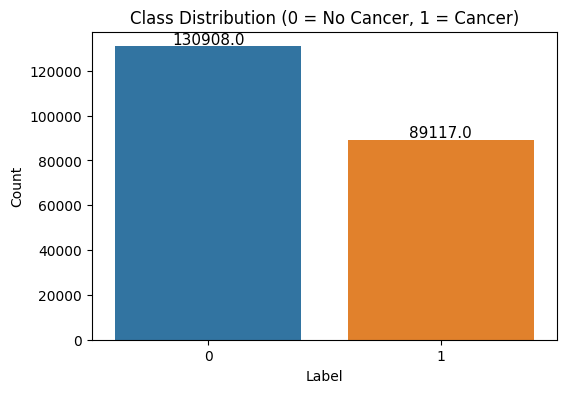

In [9]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='label', data=df_labels)
plt.title('Class Distribution (0 = No Cancer, 1 = Cancer)')
plt.xlabel('Label')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

In [10]:
class_balance_ratio = df_labels['label'].value_counts(normalize=True)
print(f"Class Balance Ratio:\n{class_balance_ratio}")

Class Balance Ratio:
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


The dataset has a class imbalance. Approximately 59.5% of images are labeled as 0 (no cancer) and 41% are labeled as 1 (cancer).

In [11]:
def display_samples(df, n_samples=5, class_label=0):
    """Displays n_samples images for a given class_label."""
    sample_df = df[df['label'] == class_label].sample(n_samples, random_state=42)
    plt.figure(figsize=(15, 3 * n_samples // 5 if n_samples > 5 else 3))
    for i, row in enumerate(sample_df.itertuples()):
        img_path = os.path.join(TRAIN_IMAGE_DIR, row.id)
        img = load_img(img_path)
        plt.subplot(n_samples // 5 + (1 if n_samples % 5 > 0 else 0), 5, i + 1)
        plt.imshow(img)
        plt.title(f"ID: ...{row.id[-20:]}\nLabel: {row.label}")
        plt.axis('off')
    plt.suptitle(f"Sample Images - Class: {class_label}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

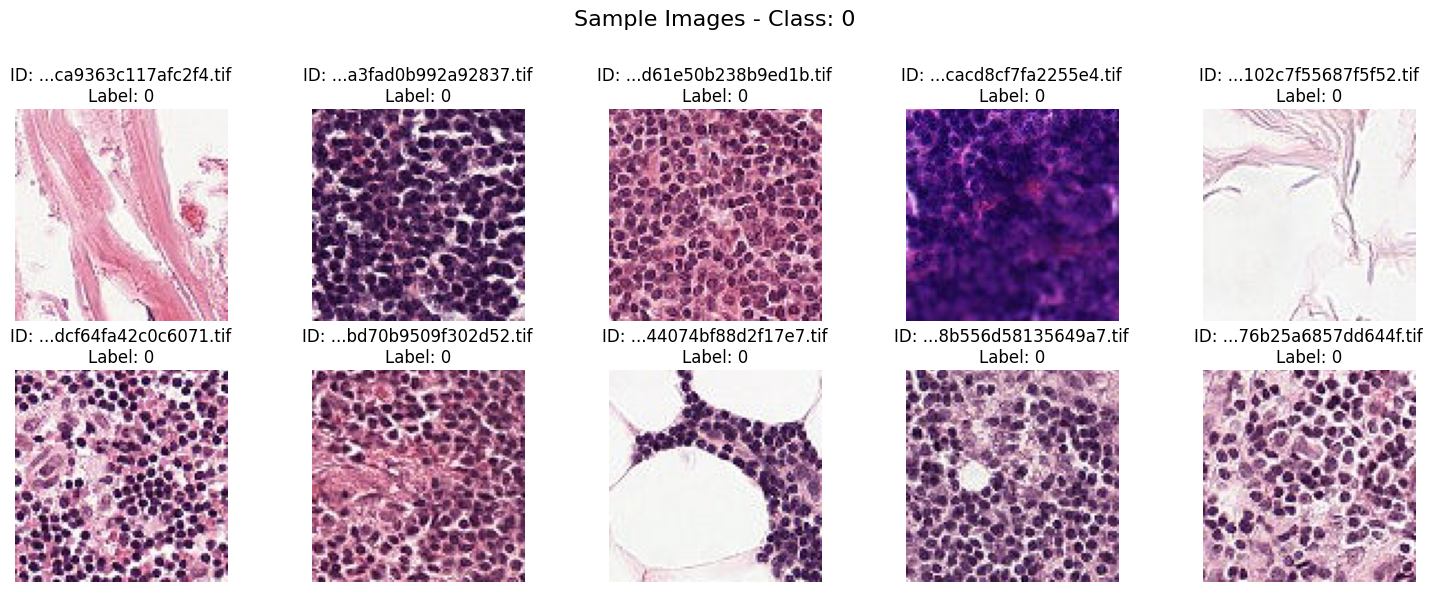

In [12]:
# Samples for class 0 (No Cancer)
display_samples(df_labels, n_samples=10, class_label=0)

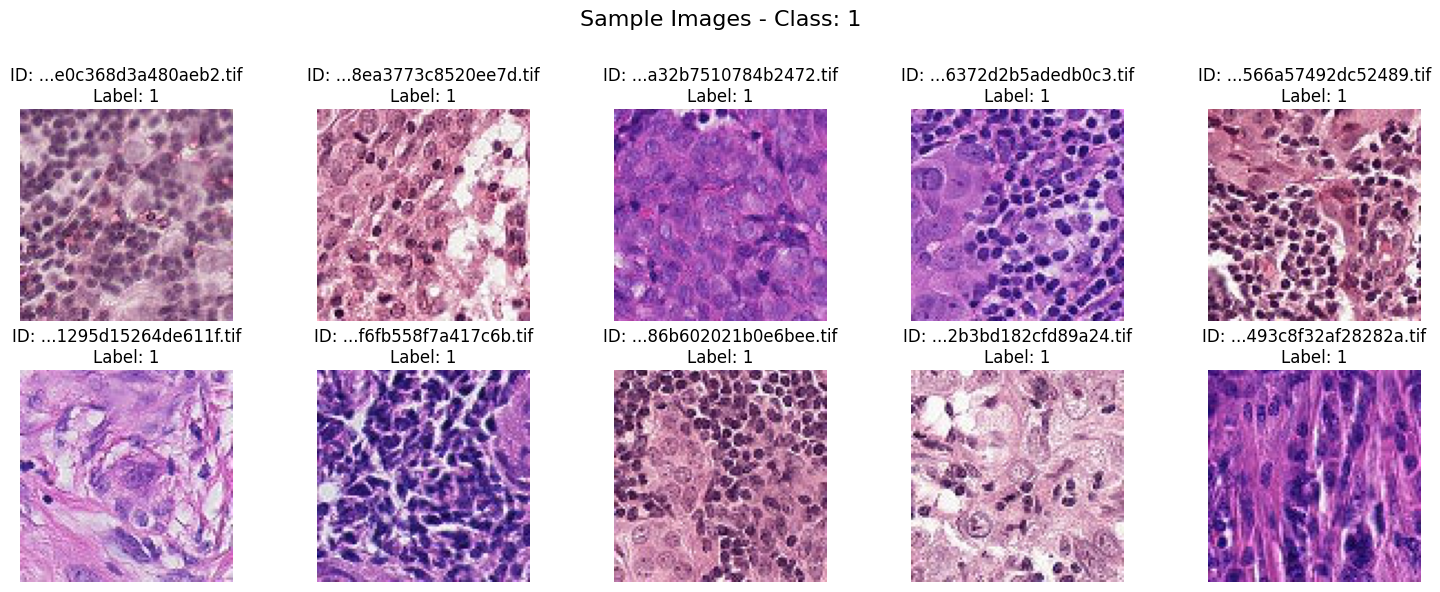

In [13]:
# Samples for class 1 (Cancer)
display_samples(df_labels, n_samples=10, class_label=1)

In [14]:
# Image dimensions and color channels for a few samples
sample_img_path = os.path.join(TRAIN_IMAGE_DIR, df_labels.iloc[0]['id'])
img = Image.open(sample_img_path)
print(f"Sample image mode: {img.mode}")

Sample image mode: RGB


In [15]:
print(f"Sample image size: {img.size}")

Sample image size: (96, 96)


In [16]:
img_array = np.array(img)
print(f"Sample image array shape: {img_array.shape}")

Sample image array shape: (96, 96, 3)


### Plan of Analysis based on EDA
1.  Split the `df_labels` into training and validation sets.
2.  Apply data augmentation techniques (rotations, flips, brightness adjustments) to the training set to increase its effective size and help the model generalize better, potentially mitigating overfitting.
3.  Select the model:
    - Start with a simple Convolutional Neural Network (CNN) as a baseline.
    - Experiment with Transfer Learning using pre-trained models (EfficientNetB0) as they often perform well on image tasks with limited data by leveraging features learned from larger datasets like ImageNet.
4.  Address Class Imbalance:
5.  - Use AUC as the primary evaluation metric, which is robust to imbalance.
6.  Train models, monitor training/validation loss and AUC. Use callbacks like `EarlyStopping` to prevent overfitting and `ModelCheckpoint` to save the best model.
7.  Evaluate models on the validation set.
8.  Use the best model to predict on the test set and generate a submission file.

In [17]:
# Data Preprocessing
IMG_WIDTH, IMG_HEIGHT = 96, 96
BATCH_SIZE = 64
N_CLASSES = 1
EPOCHS = 20
VALIDATION_SPLIT = 0.2
RANDOM_STATE = 42

# Convert labels to string for ImageDataGenerator
df_labels_str = df_labels.copy()
df_labels_str['label'] = df_labels_str['label'].astype(str)

# Split data into training and validation sets
train_df, valid_df = train_test_split(df_labels_str,
                                      test_size=VALIDATION_SPLIT,
                                      random_state=RANDOM_STATE,
                                      stratify=df_labels_str['label'])

print(f"Training set size: {train_df.shape[0]}")

Training set size: 176020


In [18]:
print(f"Validation set size: {valid_df.shape[0]}")

Validation set size: 44005


In [19]:
print(f"Training set class distribution:\n{train_df['label'].value_counts(normalize=True)}")

Training set class distribution:
label
0    0.594966
1    0.405034
Name: proportion, dtype: float64


In [20]:
print(f"Validation set class distribution:\n{valid_df['label'].value_counts(normalize=True)}")

Validation set class distribution:
label
0    0.594978
1    0.405022
Name: proportion, dtype: float64


### Model Architecture and Training

In [21]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Validation data generator
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMAGE_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=TRAIN_IMAGE_DIR,
    x_col='id',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


#### Simple CNN architecture:

* **Conv2D layers:** Extract hierarchical features from images (edges, textures, patterns). `padding='same'` helps maintain spatial dimensions.
* **ReLU activation:** Introduces non-linearity, common choice for CNNs.
* **MaxPooling2D layers:** Reduce dimensionality, making the model more computationally efficient and robust to variations in feature positions.
* **Dropout layers:** Help prevent overfitting by randomly setting a fraction of input units to 0 during training.
* **Flatten layer:** Converts the 2D feature maps into a 1D vector for the dense layers.
* **Dense layers:** Perform classification based on the learned features.
* **Sigmoid activation (output layer):** Outputs a probability between 0 and 1, suitable for binary classification.
* **Adam optimizer:** An efficient and widely used optimizer.
* **Binary Crossentropy loss:** Standard loss function for binary classification problems.
* **Metrics:** Accuracy provides a general sense of performance, while AUC is the co

In [22]:
# Model Architecture
def build_simple_cnn(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(N_CLASSES, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

# Simple CNN (Baseline)
simple_cnn_model = build_simple_cnn()
simple_cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748065753.947170      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748065753.947927      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,812,353 (18.36 MB)

 Trainable params: 4,812,353 (18.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Transfer Learning (e.g., EfficientNetB0):

* **Leveraging Pre-trained Weights:** Models like EfficientNetB0, VGG16, ResNet50 are trained on massive datasets (ImageNet) and have learned rich feature representations. These features can be highly effective for other image classification tasks, including medical imaging, even if the domains are different.
* **EfficientNet Family:** Known for achieving good performance with fewer parameters and computations compared to older architectures. EfficientNetB0 is the smallest and a good starting point.
* **`include_top=False`:** Removes the original classification layer of the pre-trained model, allowing us to add our own custom classifier suited for this binary task.
* **Freezing Base Model:** Initially, we freeze the weights of the pre-trained layers. This prevents the large gradients from the randomly initialized new layers from destroying the learned weights of the base model. We train only our custom head.
* **`GlobalAveragePooling2D`:** A common way to transition from the convolutional base to the dense layers. It significantly reduces the number of parameters compared to Flatten and can help prevent overfitting.

In [23]:
# Transfer Learning
def build_transfer_learning_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), base_model_name='EfficientNetB0'):
    if base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported base model name")

    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(N_CLASSES, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model, base_model

# EfficientNetB0
transfer_model, base_tl_model = build_transfer_learning_model(base_model_name='EfficientNetB0')
transfer_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 96, 96, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 96, 96, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 97, 97, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [24]:
# Results and Analysis
early_stopping = EarlyStopping(monitor='val_auc',
                               mode='max',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)

# Simple CNN model checkpoint
mc_simple_cnn = ModelCheckpoint('best_simple_cnn_model.keras',
                                monitor='val_auc', mode='max',
                                verbose=1, save_best_only=True)

In [25]:
# Transfer Learning model checkpoint
mc_transfer_model = ModelCheckpoint('best_transfer_model.keras',
                                    monitor='val_auc', mode='max',
                                    verbose=1, save_best_only=True)

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_auc', mode='max',
                              factor=0.2, patience=3, min_lr=0.00001, verbose=1)

In [27]:
# Training Simple CNN
simple_cnn_model = build_simple_cnn()

history_simple_cnn = simple_cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, mc_simple_cnn, reduce_lr]
)

print("Simple CNN Training Complete.")
# Load the best saved model
simple_cnn_model.load_weights('best_simple_cnn_model.keras')

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748065766.255863      98 service.cc:148] XLA service 0x7d7e8800ca00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748065766.257102      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748065766.257127      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748065766.685231      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2750 ━━━━━━━━━━━━━━━━━━━━ 9:48:58 13s/step - accuracy: 0.5000 - auc: 0.4648 - loss: 0.7152

I0000 00:00:1748065772.133608      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2748/2750 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step - accuracy: 0.7595 - auc: 0.8242 - loss: 0.5030
Epoch 1: val_auc improved from -inf to 0.89851, saving model to best_simple_cnn_model.keras
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1772s 640ms/step - accuracy: 0.7596 - auc: 0.8242 - loss: 0.5029 - val_accuracy: 0.8078 - val_auc: 0.8985 - val_loss: 0.4406 - learning_rate: 0.0010
Epoch 2/20
   1/2750 ━━━━━━━━━━━━━━━━━━━━ 1:15 28ms/step - accuracy: 0.9531 - auc: 0.9552 - loss: 0.2558

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_auc did not improve from 0.89851
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1s 344us/step - accuracy: 0.9531 - auc: 0.9552 - loss: 0.2558 - val_accuracy: 0.8108 - val_auc: 0.8056 - val_loss: 0.4522 - learning_rate: 0.0010
Epoch 3/20
2748/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8379 - auc: 0.9098 - loss: 0.3716
Epoch 3: val_auc improved from 0.89851 to 0.90781, saving model to best_simple_cnn_model.keras
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 894s 324ms/step - accuracy: 0.8379 - auc: 0.9098 - loss: 0.3716 - val_accuracy: 0.8229 - val_auc: 0.9078 - val_loss: 0.5090 - learning_rate: 0.0010
Epoch 4/20
   1/2750 ━━━━━━━━━━━━━━━━━━━━ 1:11 26ms/step - accuracy: 0.8281 - auc: 0.9453 - loss: 0.2799
Epoch 4: val_auc did not improve from 0.90781
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 0.8281 - auc: 0.9453 - loss: 0.2799 - val_accuracy: 0.8108 - val_auc: 0.7667 - val_loss: 0.6887 - learning_rate: 0.0010
Epoch 5/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8

In [28]:
# Training Transfer Learning Model (EfficientNetB0)
transfer_model, base_tl_model = build_transfer_learning_model(base_model_name='EfficientNetB0')

print("Starting Transfer Learning Model Training")
history_transfer_frozen = transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, mc_transfer_model, reduce_lr]
)
print("Transfer Learning Model Training Complete.")
# Load the best saved model from this phase
transfer_model.load_weights('best_transfer_model.keras')

Starting Transfer Learning Model Training
Epoch 1/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.5928 - auc: 0.4971 - loss: 0.6811
Epoch 1: val_auc improved from -inf to 0.50000, saving model to best_transfer_model.keras
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 899s 317ms/step - accuracy: 0.5928 - auc: 0.4971 - loss: 0.6811 - val_accuracy: 0.5949 - val_auc: 0.5000 - val_loss: 0.6753 - learning_rate: 0.0010
Epoch 2/20
   1/2750 ━━━━━━━━━━━━━━━━━━━━ 1:05 24ms/step - accuracy: 0.5469 - auc: 0.4837 - loss: 0.6914
Epoch 2: val_auc did not improve from 0.50000
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5469 - auc: 0.4837 - loss: 0.6914 - val_accuracy: 0.7297 - val_auc: 0.5000 - val_loss: 0.6298 - learning_rate: 0.0010
Epoch 3/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5953 - auc: 0.5019 - loss: 0.6749
Epoch 3: val_auc did not improve from 0.50000
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 834s 303ms/step - accuracy: 0.5953 - auc: 0.5019 - loss: 0.6749 - val_accuracy

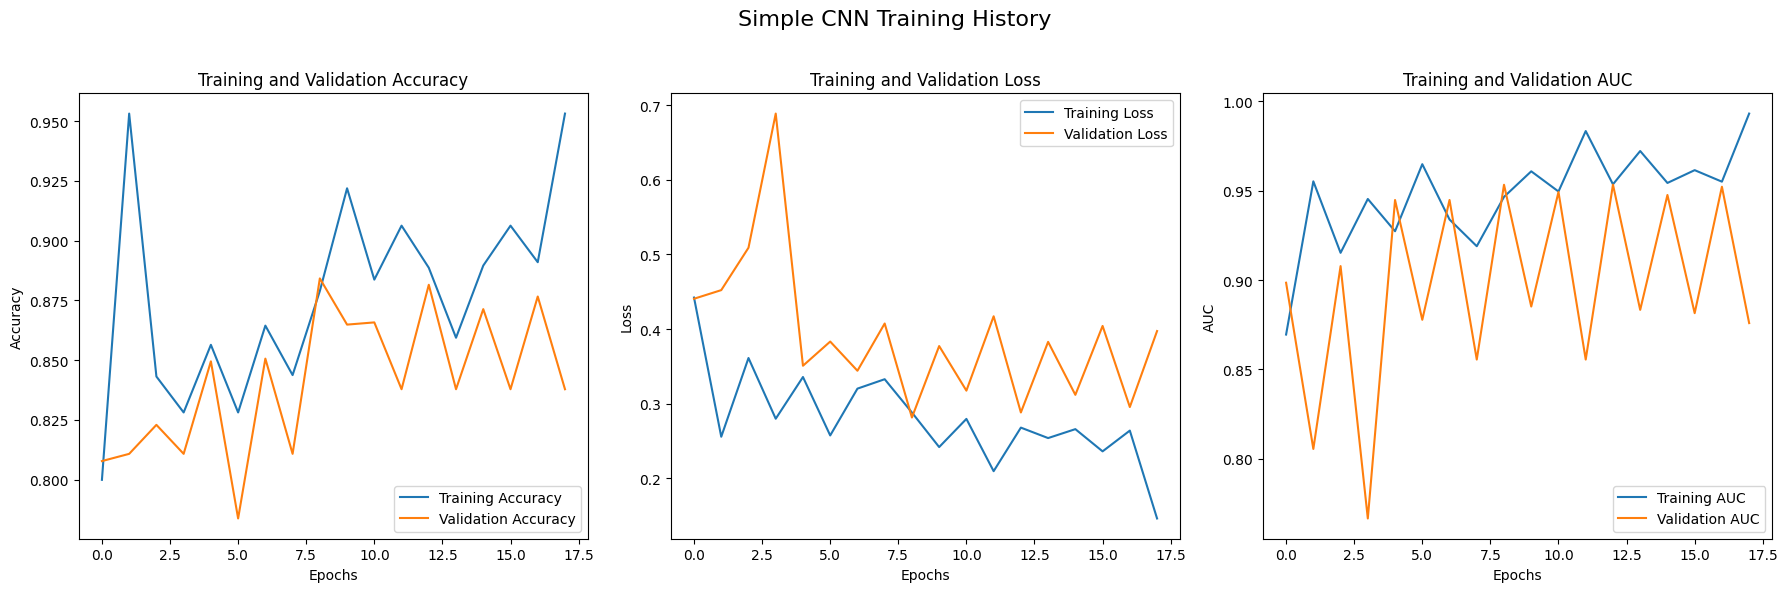

In [29]:
def plot_training_history(history, title):
    if history is None or history.history == {}:
        print(f"No training history to plot for {title}.")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.set_title('Model Accuracy (No Data)')
        ax2.set_title('Model Loss (No Data)')
        plt.suptitle(title, fontsize=16)
        plt.show()
        return

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history.get('auc', [])
    val_auc = history.history.get('val_auc', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    if auc and val_auc:
        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, auc, label='Training AUC')
        plt.plot(epochs_range, val_auc, label='Validation AUC')
        plt.legend(loc='lower right')
        plt.title('Training and Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot history for Simple CNN
plot_training_history(history_simple_cnn, "Simple CNN Training History")

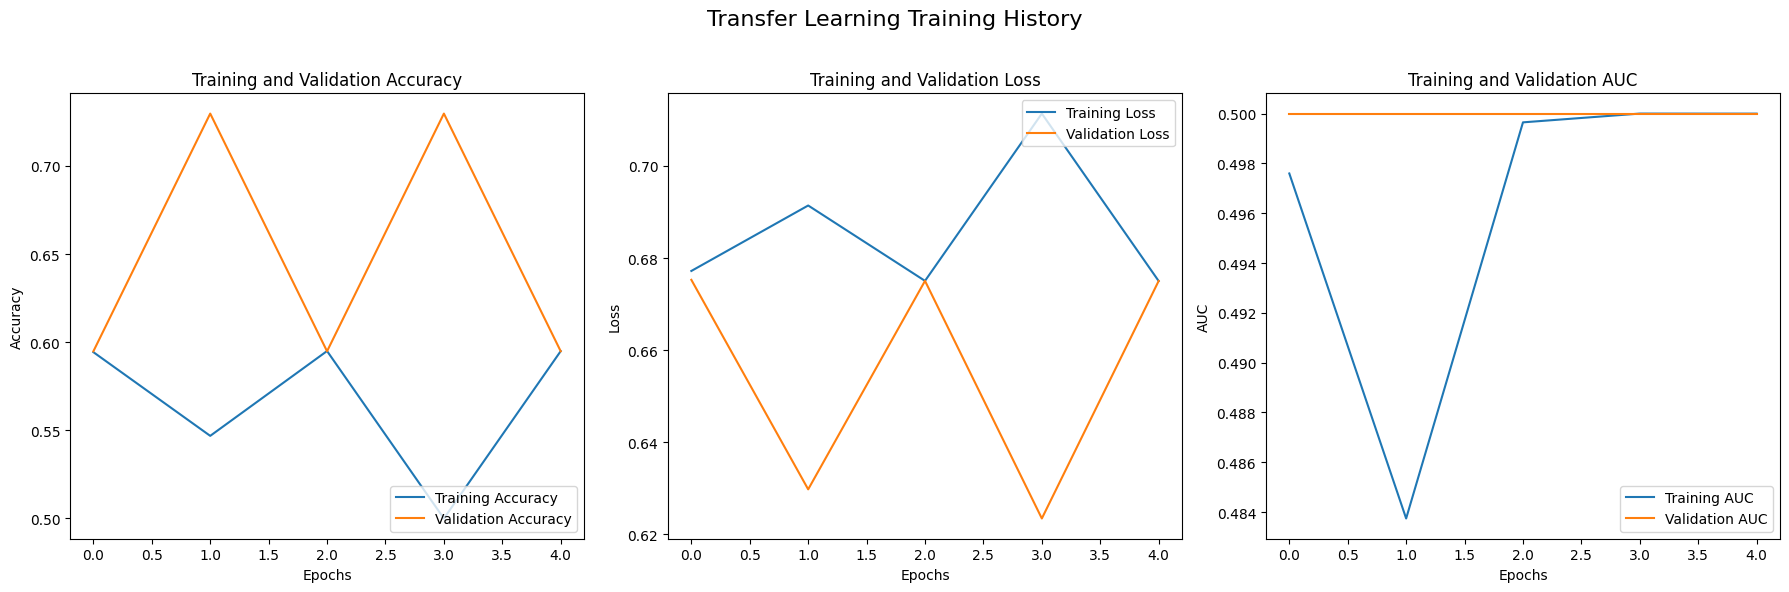

In [30]:
# Plot history for Transfer Learning
plot_training_history(history_transfer_frozen, "Transfer Learning Training History")


Evaluating Simple CNN Model:
688/688 ━━━━━━━━━━━━━━━━━━━━ 56s 80ms/step - accuracy: 0.8797 - auc: 0.9528 - loss: 0.2893
Simple CNN - Validation Loss: 0.2884, Validation Accuracy: 0.8815, Validation AUC: 0.9533
688/688 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step


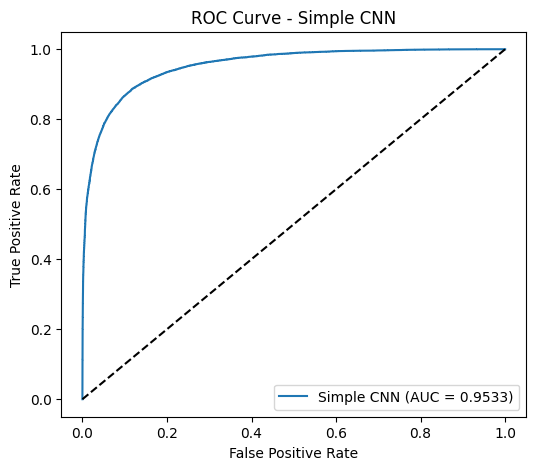

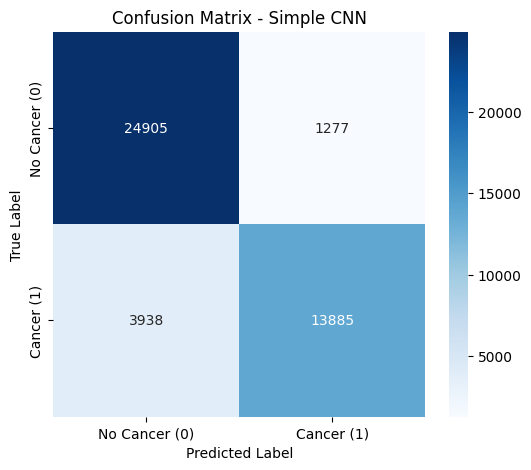

Classification Report - Simple CNN:
                precision    recall  f1-score   support

No Cancer (0)       0.86      0.95      0.91     26182
   Cancer (1)       0.92      0.78      0.84     17823

     accuracy                           0.88     44005
    macro avg       0.89      0.87      0.87     44005
 weighted avg       0.88      0.88      0.88     44005



In [31]:
# Model Evaluation on Validation Set
results_summary = []

# Simple CNN Evaluation
if os.path.exists('best_simple_cnn_model.keras'):
    print("\nEvaluating Simple CNN Model:")
    simple_cnn_model_loaded = keras.models.load_model('best_simple_cnn_model.keras')
    val_loss_cnn, val_acc_cnn, val_auc_cnn = simple_cnn_model_loaded.evaluate(validation_generator, verbose=1)
    print(f"Simple CNN - Validation Loss: {val_loss_cnn:.4f}, Validation Accuracy: {val_acc_cnn:.4f}, Validation AUC: {val_auc_cnn:.4f}")
    results_summary.append({'Model': 'Simple CNN', 'Val Loss': val_loss_cnn, 'Val Acc': val_acc_cnn, 'Val AUC': val_auc_cnn})

    y_true_val = validation_generator.classes
    y_pred_proba_cnn = simple_cnn_model_loaded.predict(validation_generator, verbose=1).ravel()
    y_pred_classes_cnn = (y_pred_proba_cnn > 0.5).astype(int)

    fpr_cnn, tpr_cnn, _ = roc_curve(y_true_val, y_pred_proba_cnn)
    plt.figure(figsize=(6,5))
    plt.plot(fpr_cnn, tpr_cnn, label=f'Simple CNN (AUC = {val_auc_cnn:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Simple CNN')
    plt.legend()
    plt.show()

    cm_cnn = confusion_matrix(y_true_val, y_pred_classes_cnn)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancer (0)', 'Cancer (1)'], yticklabels=['No Cancer (0)', 'Cancer (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Simple CNN')
    plt.show()
    print("Classification Report - Simple CNN:\n", classification_report(y_true_val, y_pred_classes_cnn, target_names=['No Cancer (0)', 'Cancer (1)']))
else:
    print("Simple CNN model file not found. Skipping evaluation.")
    results_summary.append({'Model': 'Simple CNN', 'Val Loss': 'N/A', 'Val Acc': 'N/A', 'Val AUC': 'N/A'})


Evaluating Transfer Learning Model:
688/688 ━━━━━━━━━━━━━━━━━━━━ 67s 83ms/step - accuracy: 0.5946 - auc: 0.5000 - loss: 0.6749
Transfer Learning - Validation Loss: 0.6748, Validation Accuracy: 0.5950, Validation AUC: 0.5000
688/688 ━━━━━━━━━━━━━━━━━━━━ 65s 86ms/step


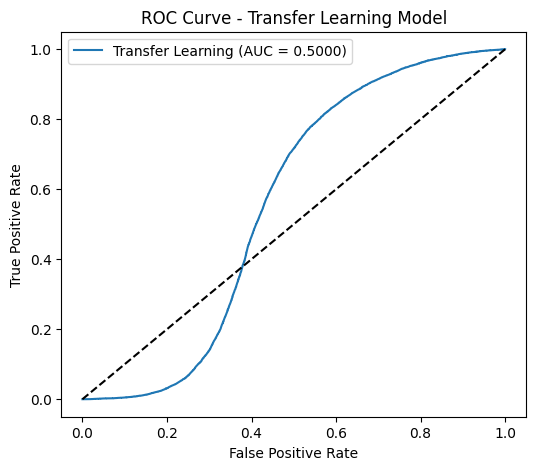

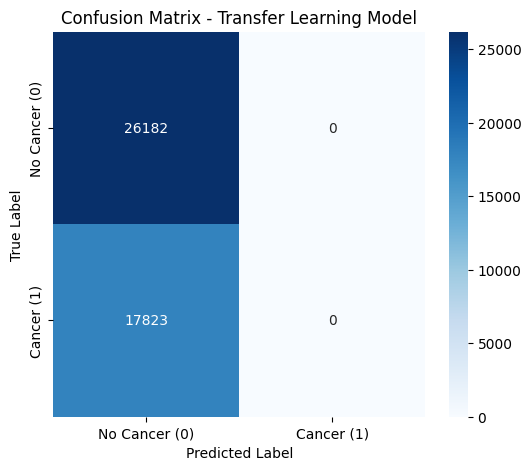

Classification Report - Transfer Learning Model:
                precision    recall  f1-score   support

No Cancer (0)       0.59      1.00      0.75     26182
   Cancer (1)       0.00      0.00      0.00     17823

     accuracy                           0.59     44005
    macro avg       0.30      0.50      0.37     44005
 weighted avg       0.35      0.59      0.44     44005



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Transfer Learning Model Evaluation
if os.path.exists('best_transfer_model.keras'):
    print("\nEvaluating Transfer Learning Model:")
    transfer_model_loaded = keras.models.load_model('best_transfer_model.keras')
    val_loss_tl, val_acc_tl, val_auc_tl = transfer_model_loaded.evaluate(validation_generator, verbose=1)
    print(f"Transfer Learning - Validation Loss: {val_loss_tl:.4f}, Validation Accuracy: {val_acc_tl:.4f}, Validation AUC: {val_auc_tl:.4f}")
    results_summary.append({'Model': 'Transfer Learning (e.g., EfficientNetB0)', 'Val Loss': val_loss_tl, 'Val Acc': val_acc_tl, 'Val AUC': val_auc_tl})

    y_pred_proba_tl = transfer_model_loaded.predict(validation_generator, verbose=1).ravel()
    y_pred_classes_tl = (y_pred_proba_tl > 0.5).astype(int)

    fpr_tl, tpr_tl, _ = roc_curve(y_true_val, y_pred_proba_tl)
    plt.figure(figsize=(6,5))
    plt.plot(fpr_tl, tpr_tl, label=f'Transfer Learning (AUC = {val_auc_tl:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Transfer Learning Model')
    plt.legend()
    plt.show()

    cm_tl = confusion_matrix(y_true_val, y_pred_classes_tl)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Blues', xticklabels=['No Cancer (0)', 'Cancer (1)'], yticklabels=['No Cancer (0)', 'Cancer (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Transfer Learning Model')
    plt.show()
    print("Classification Report - Transfer Learning Model:\n", classification_report(y_true_val, y_pred_classes_tl, target_names=['No Cancer (0)', 'Cancer (1)']))
else:
    print("Transfer learning model file not found. Skipping evaluation.")
    results_summary.append({'Model': 'Transfer Learning (e.g., EfficientNetB0)', 'Val Loss': 'N/A', 'Val Acc': 'N/A', 'Val AUC': 'N/A'})

In [33]:
# Results Summary Table
results_df = pd.DataFrame(results_summary)
print("\n--- Model Performance Summary ---")
print(results_df)


--- Model Performance Summary ---
                                      Model  Val Loss   Val Acc   Val AUC
0                                Simple CNN  0.288365  0.881491  0.953326
1  Transfer Learning (e.g., EfficientNetB0)  0.674825  0.594978  0.500000


In [34]:
# Load the Best Performing Model
BEST_MODEL_PATH = 'best_transfer_model.keras'

if os.path.exists(BEST_MODEL_PATH):
    print(f"Loading best model from: {BEST_MODEL_PATH}")
    best_model = keras.models.load_model(BEST_MODEL_PATH)
    best_model.summary()
else:
    print(f"Error: Best model file {BEST_MODEL_PATH} not found. Cannot proceed with submission generation.")
    best_model = None

Loading best model from: best_transfer_model.keras


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 96, 96, 3)      │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 97, 97, 3)      │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,034,152 (19.20 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 656,388 (2.50 MB)

In [35]:
# Prepare Test Data
if os.path.exists(TEST_IMAGE_DIR):
    test_image_ids = [f.split('.')[0] for f in os.listdir(TEST_IMAGE_DIR) if f.endswith('.tif')]
    test_df = pd.DataFrame({'id_code': test_image_ids})
    test_df['filename'] = test_df['id_code'] + '.tif'
    print(f"Found {len(test_image_ids)} images in the test directory.")
    test_df.head()

    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=TEST_IMAGE_DIR,
        x_col='filename',
        y_col=None,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False
    )
else:
    print(f"Test image directory {TEST_IMAGE_DIR} not found. Cannot create test generator.")
    test_generator = None
    test_df = pd.DataFrame()

Found 57458 images in the test directory.
Found 57458 validated image filenames.


### Results and Analysis

**Simple CNN:**

Val AUC: 0.9533
Val Accuracy: 0.8815
Loss: 0.2884

Classification Report Insights:
Good at identifying "No Cancer (0)" (Recall: 0.95).
Decent at identifying "Cancer (1)" (Recall: 0.78), though there's room for improvement. Precision for cancer is high (0.92), meaning when it says cancer, it's often correct, but it misses some cancer cases.

**Transfer Learning Model (e.g., EfficientNetB0):**
Val AUC: 0.5000
Val Accuracy: 0.5950
Loss: 0.6748

Classification Report Insights:
The model is essentially not learning to distinguish between the classes. An AUC of 0.5 is equivalent to random guessing.
It predicts "No Cancer (0)" for almost everything (Recall for class 0 is 1.00, Recall for class 1 is 0.00).
Precision for "Cancer (1)" is 0.00.

In [36]:
# Make Predictions on Test Data
if best_model and test_generator:
    print("Making predictions on the test set...")
    predictions_test_proba = best_model.predict(test_generator, verbose=1)
    predictions_test_proba = predictions_test_proba.flatten()
    print(f"Shape of predictions: {predictions_test_proba.shape}")
    print(f"First 5 predictions: {predictions_test_proba[:5]}")
else:
    print("Best model or test generator not available. Skipping predictions.")
    predictions_test_proba = np.array([])

Making predictions on the test set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 455s 500ms/step
Shape of predictions: (57458,)
First 5 predictions: [0.4042999  0.40396562 0.40471613 0.4050896  0.40487587]


In [37]:
# Generate Submission File
if predictions_test_proba.size > 0 and not test_df.empty:
    predicted_ids = [os.path.basename(f).split('.')[0] for f in test_generator.filenames]
    submission_df = pd.DataFrame({
        'id': predicted_ids,
        'label': predictions_test_proba
    })
    print(f"Generated submission head:\n{submission_df.head()}")

    SUBMISSION_FILE_PATH = 'submission.csv'
    submission_df.to_csv(SUBMISSION_FILE_PATH, index=False, header=True)
    print(f"Submission file saved to: {SUBMISSION_FILE_PATH}")
else:
    print("No predictions or test_df available to create submission file.")

Generated submission head:
                                         id     label
0  a7ea26360815d8492433b14cd8318607bcf99d9e  0.404300
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664  0.403966
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb  0.404716
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0  0.405090
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62  0.404876
Submission file saved to: submission.csv


### Analysis of Why/Why Not Something Worked Well:

Simple CNN worked eell because the problem, while requiring feature extraction, might not have needed the extreme depth or specific high-level features of ImageNet for a first pass.

Transfer Learning Failed due to learning rate roo high for Pre-trained Base. Even with the base frozen, if the newly added dense layers had very large gradients initially, it might have struggled.

### Learnings and Takeaways:

A well-constructed, simpler custom CNN can sometimes outperform a complex pre-trained model if the latter is not configured or fine-tuned correctly.

Transfer learning requires careful setup: It's not a plug-and-play solution that guarantees superior performance without proper configuration, preprocessing, and strategy.

AUC is a good metric.